In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import matthews_corrcoef, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [9]:
import os
print(os.getcwd())

/workspaces/pickering-remote-dashboard/model_content


In [ ]:
# # Run the main function
# file_path1 = '/workspaces/pickering-remote-dashboard/model_content/TuriTapFlow_Data_for_FR_Modeling.xlsx - 1_.25_.4_1.65_2.1_3.8_.7_.1_.18.csv'
# # file_path2 = 'RedRock_Spring_0.1_0.2_0.4mgL.csv'

# csv1 = pd.read_csv(file_path1)
# # csv2 = pd.read_csv(file_path2)

# # combined_df = pd.concat([csv1, csv2], ignore_index=True)

# # combined_df.head(5)

# # combined_df.to_csv('RedRock_comprehensive_mgL.csv', index=False) 
# # csv1.to_csv('RedRock_comprehensive_mgL.csv', index=False) 

# print('df succesful')

df succesful


In [10]:
# Van Haute 
def van_haute_model(orp, ph):
    intercept = 0.44
    orp_coeff = -0.015
    orp_squared_coeff = 1.1e-5
    interaction_coeff = 8.4e-4
    log_fcr = (intercept 
               + orp_coeff * orp 
               + orp_squared_coeff * (orp ** 2) 
               + interaction_coeff * (orp * ph))
    base_10 = 10 ** log_fcr
    base_e = np.exp(log_fcr)
    return base_10, base_e  # Convert log FCR to FCR

def load_data(file_path):
    data = pd.read_csv(file_path)
    van_data = data.copy()
    van_data['Van_Haute_FCR_base10'], van_data['Van_Haute_FCR_basee'] = van_haute_model(van_data['ORP (mV)'], van_data['pH'])
    return data, van_data

# Prepare data 
def prepare_data(data):
    X = data[['ORP (mV)', 'pH']]
    y = data['FCR_True']

    # Randomly shuffle 
    shuffled_indices = np.random.permutation(len(X))
    X = X.iloc[shuffled_indices].reset_index(drop=True)
    y = y.iloc[shuffled_indices].reset_index(drop=True)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, scaler

# Build and train the Random Forest model
def build_and_train_rf(X_train, y_train):
    rf_model = RandomForestRegressor(n_estimators=50, random_state=42) # n_estimators is the the number of trees in the forest.
    rf_model.fit(X_train, y_train)
    return rf_model

# Evaluate 
def evaluate_model(rf_model, X_test, y_test, scaler, data, van_data):
    predictions = rf_model.predict(X_test)
    
    # Sort y_test and associated arrays
    sorted_indices = np.argsort(y_test)
    y_test_sorted = y_test.iloc[sorted_indices]
    predictions_sorted = predictions[sorted_indices]
    van_haute_fcr_sorted_10 = van_data['Van_Haute_FCR_base10'].values[-len(y_test):][sorted_indices]
    van_haute_fcr_sorted_e = van_data['Van_Haute_FCR_basee'].values[-len(y_test):][sorted_indices]
    
    # Calculate metrics
    mae = round(mean_absolute_error(y_test, predictions), 3)
    mse = round(mean_squared_error(y_test, predictions), 3)
    rmse = round(np.sqrt(mse), 3)
    r2 = round(r2_score(y_test, predictions), 3)

    # Print metrics
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R^2 Score: {r2}")

    # Plotting the results with dots only
    plt.figure(figsize=(14, 7))
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, color='blue', label='Actual FCR',s=50)
    plt.scatter(range(len(predictions_sorted)), predictions_sorted, color='green', label='Random Forest Predicted FCR', s=50)
    plt.scatter(range(len(van_haute_fcr_sorted_10)), van_haute_fcr_sorted_10, color='orange', label='Van Haute Model FCR, base 10', s=50)
    plt.scatter(range(len(van_haute_fcr_sorted_e)), van_haute_fcr_sorted_e, color='yellow', label='Van Haute Model FCR, base e', s=50)
    
    # Draw horizontal lines
    plt.axhline(y=0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.12, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.2, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.42, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.25, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.70, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=2.0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=3.0, color='blue', linestyle='--', linewidth=0.8)
    
    plt.title("FCR Prediction vs Actual and Van Haute Model")
    plt.xlabel("Individual Timestamps Sorted by FCR_True)")
    plt.ylabel("FCR Value")
    plt.legend()
    
    # Save 
    plt.savefig("fcr_comparison_plot_full.png")  
    plt.show()

    # Second plot with y-axis limited from 0 to 3.0
    plt.figure(figsize=(14, 7))
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, color='blue', label='Actual FCR', s=50)
    plt.scatter(range(len(predictions_sorted)), predictions_sorted, color='green', label='Random Forest Predicted FCR', s=20)
    plt.scatter(range(len(van_haute_fcr_sorted_e)), van_haute_fcr_sorted_e, color='yellow', label='Van Haute Model FCR, base e', s=50)

    # Draw horizontal lines
    plt.axhline(y=0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.12, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.2, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=0.42, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.25, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.70, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=2.0, color='blue', linestyle='--', linewidth=0.8)
    plt.axhline(y=3.0, color='blue', linestyle='--', linewidth=0.8)

    # Set y-axis limits
    plt.ylim(0, 3.0)

    plt.title("FCR Prediction vs Actual and Van Haute Model (Y-axis 0 to 3.0)")
    plt.xlabel("Individual Timestamps Sorted by FCR_True")
    plt.ylabel("FCR Value")
    plt.legend()

    # Save the limited-range plot
    plt.savefig("fcr_comparison_plot_limited_range.png")  
    plt.show()

def main(file_path):
    data, van_data = load_data(file_path)
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)
    rf_model = build_and_train_rf(X_train, y_train)
    evaluate_model(rf_model, X_test, y_test, scaler, data, van_data)
    print('dataset FCR values:', data['FCR_True'].unique())
    print('dataset columns:', data.columns)
    return rf_model, scaler

Mean Absolute Error (MAE): 0.043
Mean Squared Error (MSE): 0.047
Root Mean Squared Error (RMSE): 0.217
R^2 Score: 0.97


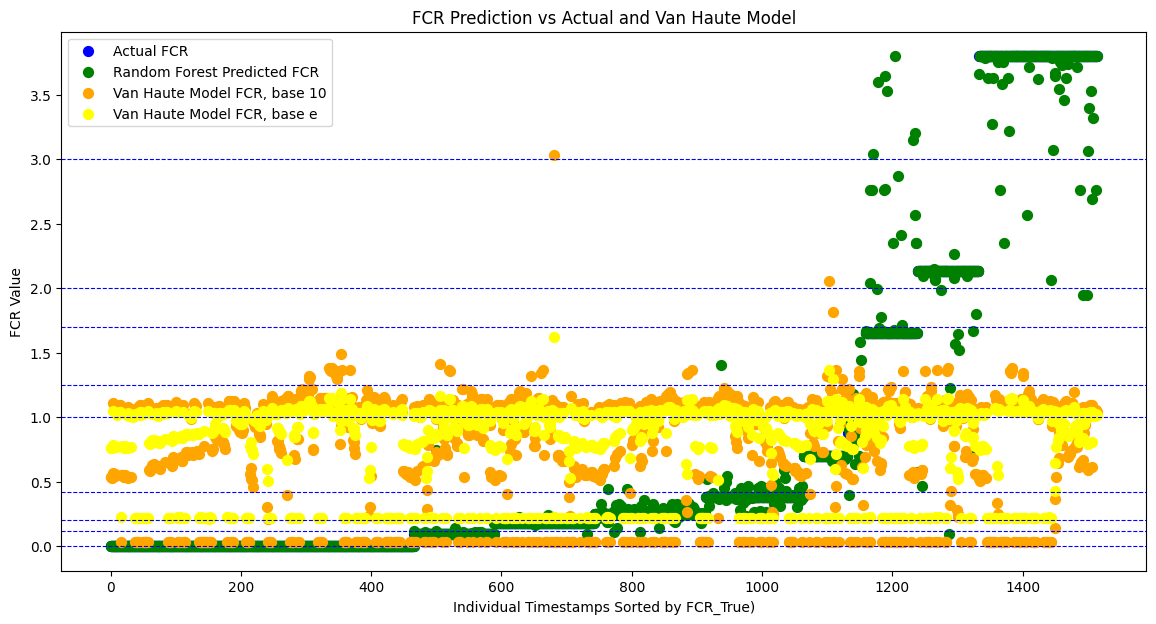

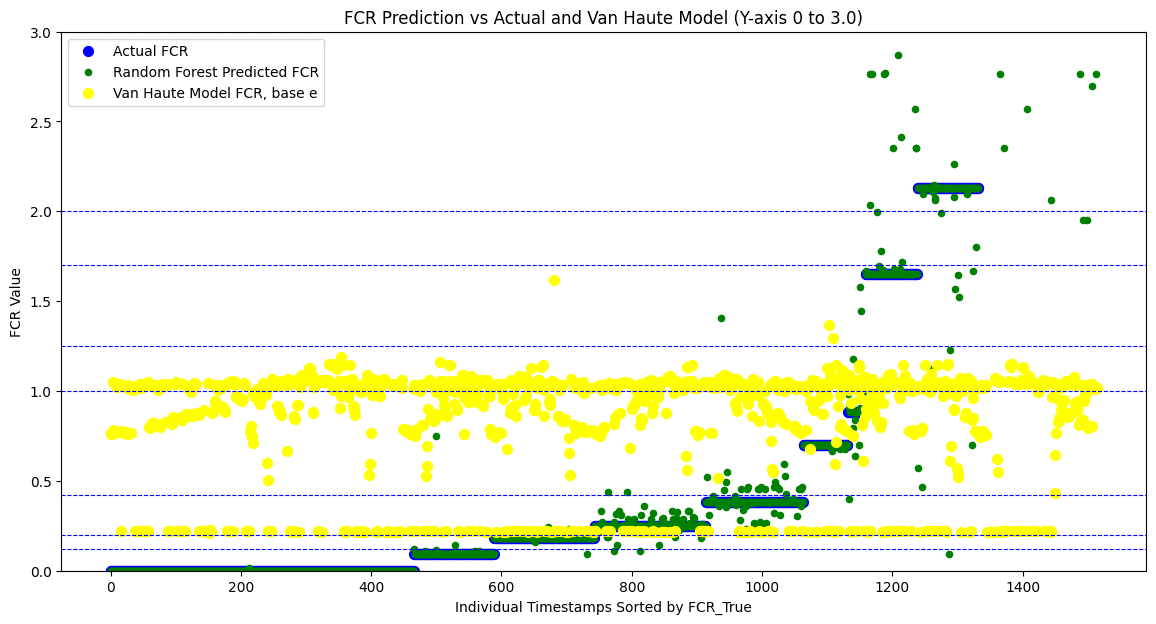

dataset FCR values: [0.   0.88 0.25 0.38 1.65 2.13 3.8  0.7  0.09 0.18]
dataset columns: Index(['created_at', 'entry_id', 'pH', 'ORP (mV)', 'Temp (degC)', 'FCR_True'], dtype='object')
plot successful


In [12]:
# combined_filepath = 'RedRock_comprehensive_mgL.csv'
turitap_flow_filepath = '/workspaces/pickering-remote-dashboard/model_content/TuriTapFlow_Data_for_FR_Modeling.xlsx - 1_.25_.4_1.65_2.1_3.8_.7_.1_.18.csv'
rf_model, scaler = main(turitap_flow_filepath)
print("plot successful")

In [13]:
# Save model 

from joblib import dump, load
dump(rf_model, 'turitap_flow_random_forest_model.joblib')

['turitap_flow_random_forest_model.joblib']

In [14]:
dump(scaler, 'turitap_flow_scaler.joblib')

['turitap_flow_scaler.joblib']